In [1]:
import pandas as pd

# Load the dataset
labeled_df = pd.read_csv('data/new_labeled_dataset.csv')

# Preview
print(labeled_df.head())
print(labeled_df.columns)  # See available columns

                                            sentence  \
0  YouTube is making clear there will be no “birt...   
1  The increasingly bitter dispute between Americ...   
2  So while there may be a humanitarian crisis dr...   
3  A professor who teaches climate change classes...   
4  Looking around the United States, there is nev...   

                                           news_link      outlet  \
0  https://eu.usatoday.com/story/tech/2020/02/03/...   usa-today   
1  https://www.nbcnews.com/news/sports/women-s-te...       msnbc   
2  https://www.alternet.org/2019/01/here-are-5-of...    alternet   
3  https://www.breitbart.com/politics/2019/05/09/...   breitbart   
4  https://thefederalist.com/2020/03/11/woman-who...  federalist   

            topic    type  group_id  num_sent  Label_bias  \
0  elections-2020  center         1         1      Biased   
1           sport    left         1         1  Non-biased   
2     immigration    left         1         1      Biased   
3     envi

In [2]:
# Text Libraries
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
# Machine Learning Libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [4]:
# Make a copy of the original dataset
df = labeled_df.copy()

## Recode label_bias variable
# Drop rows where label_bias is 'no-agreement'
df = df[df['Label_bias'].isin(['Biased', 'Non-biased'])]

# Map to binary
df['Label_bias_binary'] = df['Label_bias'].map({'Biased': 1, 'Non-biased': 0})

print(df['Label_bias_binary'].value_counts())

Label_bias_binary
1    1018
0     533
Name: count, dtype: int64


In [5]:
## Create a new variable: n_biased_words
# Turn strings into lists
import ast
if isinstance(df['biased_words4'].iloc[0], str):
    df['biased_words4'] = df['biased_words4'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Remove stopwords
stopword = stopwords.words('english')
df['biased_words'] = df['biased_words4'].apply(lambda wordlist: [w for w in wordlist if w.lower() not in stopword])

# Calculate the # of biased words for each sentence
df['n_biased_words'] = df['biased_words'].apply(len)

In [8]:
# Select features and the target variable
features = ['sentence', 'outlet', 'topic', 'type', 'num_sent', 
            'biased_words', 'n_biased_words', 'factual_reporting', 'reliability_label']
target = 'Label_bias_binary'

X = df[features]
y = df[target]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify keeps class balance!
)

In [10]:
# Text cleaning & preprocessing
# regular expression to identify non-ascii characters
non_ascii_regex = r'[^\x00-\x7F]+'

def tokenize(text):
    text = re.sub(non_ascii_regex, ' ', text)    # Remove non-ASCII
    text = text.lower()                          # Lowercase for consistency
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # Remove punctuation
    tokens = text.split()                        # Split on whitespace
    clean_tokens = [w for w in tokens if w not in stopword]
    return clean_tokens

# Test using an example sentence
sample = "Hello! This is a test sentence: Let's see how it handles punctuation, emojis 😊, and stopwords."
print(tokenize(sample))

['hello', 'test', 'sentence', 'let', 'see', 'handles', 'punctuation', 'emojis', 'stopwords']


In [11]:
# List categorical & numerical variables
categ_cols = ['outlet', 'topic', 'type', 'factual_reporting']
num_cols = ['num_sent', 'n_biased_words', 'reliability_label']

# Text transformer with the tokenize function
text_transformer = TfidfVectorizer(
    tokenizer=tokenize, preprocessor=None, token_pattern=None,
    ngram_range=(1,2), max_features=1000
)
cat_transformer = OneHotEncoder()
num_transformer = StandardScaler()

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'sentence'),
        ('cat', cat_transformer, categ_cols),
        ('num', num_transformer, num_cols)
    ]
)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create the pipeline and train the model
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

In [21]:
from sklearn.metrics import classification_report

# Fit and evaluate
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.82      0.73       107
           1       0.89      0.78      0.83       204

    accuracy                           0.79       311
   macro avg       0.78      0.80      0.78       311
weighted avg       0.81      0.79      0.80       311



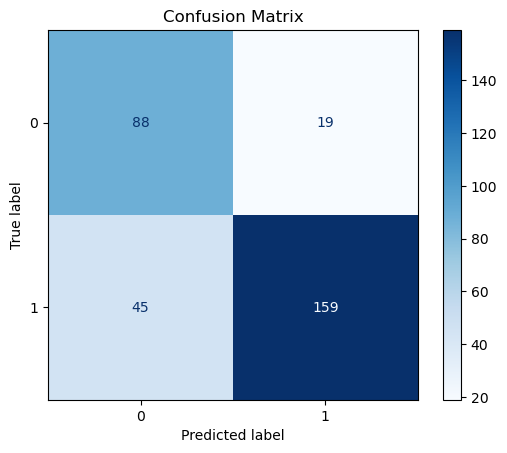

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

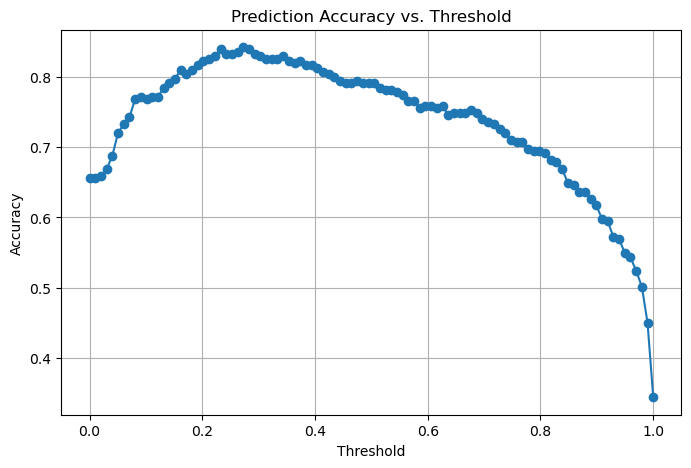

In [ ]:
## Now see how the accuracy changes with the threshold
from sklearn.metrics import accuracy_score

# Get predicted probabilities for class 1
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Create a range of thresholds to test
thresholds = np.linspace(0, 1, 100)
accuracies = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot accuracy vs. threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy vs. Threshold')
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.64      0.72       107
           1       0.83      0.92      0.87       204

    accuracy                           0.83       311
   macro avg       0.82      0.78      0.80       311
weighted avg       0.82      0.83      0.82       311



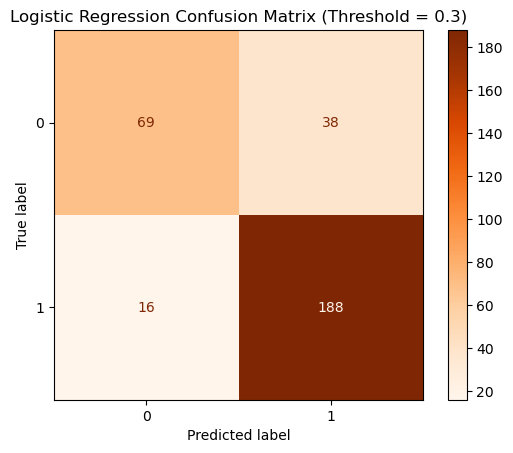

In [ ]:
## Try adjusting the threshold
threshold = 0.3
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate performance with new threshold
print(classification_report(y_test, y_pred_custom))

# Confusion matrix for custom threshold
cm_custom = confusion_matrix(y_test, y_pred)
disp_custom = ConfusionMatrixDisplay(confusion_matrix=cm_custom, display_labels=log_reg.classes_)
disp_custom.plot(cmap='Oranges')
plt.title(f'Logistic Regression Confusion Matrix (Threshold = {threshold})')
plt.show()


In [26]:
from sklearn.ensemble import RandomForestClassifier

# Set up the pipeline
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=500,  # number of trees, can tune
        min_samples_leaf = 5,
        max_depth=None,    # no max depth, can tune
        class_weight='balanced',  # helps if classes are imbalanced
        random_state=42
    ))
])

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       107
           1       0.86      0.79      0.82       204

    accuracy                           0.78       311
   macro avg       0.76      0.77      0.76       311
weighted avg       0.79      0.78      0.78       311



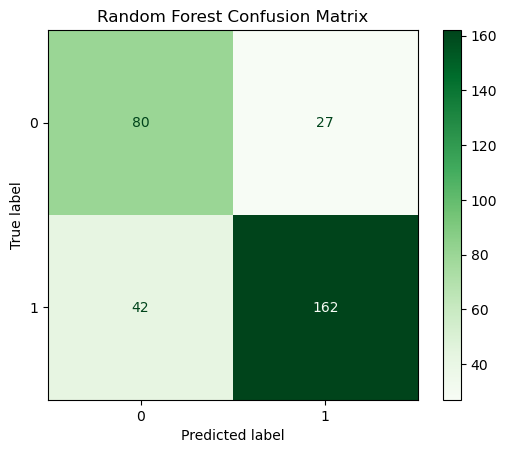

In [68]:
# Fit the random forest pipeline
rf.fit(X_train, y_train)

# Predict on the test set
y_rf_pred = rf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_rf_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.named_steps['classifier'].classes_)
disp.plot(cmap='Greens')
plt.title(f'Random Forest Confusion Matrix')
plt.show()

In [38]:
## Feature importance
# Get preprocessed feature names
text_features = preprocessor.named_transformers_['text'].get_feature_names_out()
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categ_cols)
num_features = num_cols
all_features = np.concatenate([text_features, cat_features, num_features])

rf_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf.named_steps['classifier'].feature_importances_
})
rf_feature_importance = rf_feature_importance.sort_values('importance', ascending=False)

print(rf_feature_importance.head(20))

                      feature  importance
1028           n_biased_words    0.253980
1022              type_center    0.063770
1000          outlet_alternet    0.040448
1002        outlet_federalist    0.040059
906                     trump    0.028284
1007         outlet_usa-today    0.025563
1026  factual_reporting_mixed    0.024647
760                      said    0.020022
1006           outlet_reuters    0.019862
1025   factual_reporting_high    0.015719
1029        reliability_label    0.014452
1023                type_left    0.014136
489                      like    0.013408
1027                 num_sent    0.012329
1005             outlet_msnbc    0.010359
1017              topic_sport    0.010006
993                      year    0.008650
1024               type_right    0.008377
238                 democrats    0.007263
1019   topic_trump-presidency    0.007245


In [42]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier  # You may need: pip install xgboost

In [ ]:
## Model comparison & selection
# Define each model's pipeline
models = {
    'Logistic Regression': log_reg,
    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LinearSVC(class_weight='balanced'))
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=5))  # you can tune n_neighbors
    ]),
    'Random Forest': rf,
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42,
                                     scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])))
    ]),
}

In [47]:
## Cross-validation
from sklearn.metrics import make_scorer, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    results[name] = scores
    print(f"{name} - {'f1'} scores: {scores}")
    print(f"{name} - Mean: {np.mean(scores):.3f}, Std: {np.std(scores):.3f}")


Logistic Regression - f1 scores: [0.84713376 0.84615385 0.84375    0.83673469 0.84615385]
Logistic Regression - Mean: 0.844, Std: 0.004
SVM - f1 scores: [0.84567901 0.83591331 0.84848485 0.84142395 0.85626911]
SVM - Mean: 0.846, Std: 0.007
KNN - f1 scores: [0.83333333 0.85043988 0.820059   0.84567901 0.83928571]
KNN - Mean: 0.838, Std: 0.011
Random Forest - f1 scores: [0.86068111 0.84735202 0.84829721 0.83495146 0.82580645]
Random Forest - Mean: 0.843, Std: 0.012
XGBoost - f1 scores: [0.86850153 0.85626911 0.86144578 0.85802469 0.86144578]
XGBoost - Mean: 0.861, Std: 0.004


/var/folders/rm/6mtj7p8d2fz8qhs9gm648gm80000gn/T/ipykernel_9153/2347598033.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys())


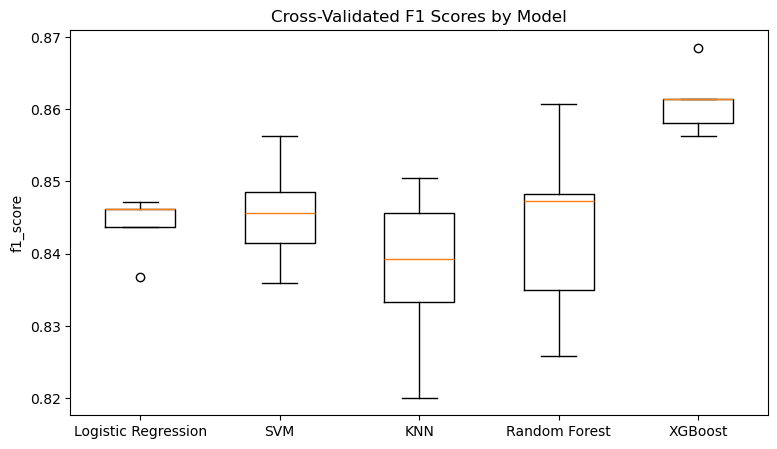

In [49]:
# Visualize results
plt.figure(figsize=(9,5))
plt.boxplot(results.values(), labels=results.keys())
plt.title(f'Cross-Validated F1 Scores by Model')
plt.ylabel('f1_score')
plt.show()


In [54]:
## XG Boost as the best-fitting model

xgb = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42,
                                     scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])))
    ])

xgb.fit(X_train, y_train)


# Hyperparamter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

gs = GridSearchCV(xgb, param_grid, scoring='f1', cv=3)
gs.fit(X_train, y_train)

print("Best parameters:", gs.best_params_)
print("Best cross-validated F1 score:", gs.best_score_)

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Best cross-validated F1 score: 0.853289942366633


In [57]:
# Recreate the model pipeline with best parameters
final_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=100,
        subsample=1.0,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
    ))
])

# Fit on the full training set
final_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=1000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  token_pattern=None,
                                                                  tokenizer=<function tokenize at 0x15b2da520>),
                                                  'sentence'),
                                                 ('cat', OneHotEncoder(),
                                                  ['outlet', 'topic', 'type',
                                                   'factual_reporting']),
                                                 ('num', StandardScaler(),
                                                  ['num_sent', 'n_biased_words',
                                                   'reliability_label'])])),
                ('cl...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

              precision    recall  f1-score   support

           0       0.69      0.79      0.73       107
           1       0.88      0.81      0.84       204

    accuracy                           0.80       311
   macro avg       0.78      0.80      0.79       311
weighted avg       0.81      0.80      0.81       311



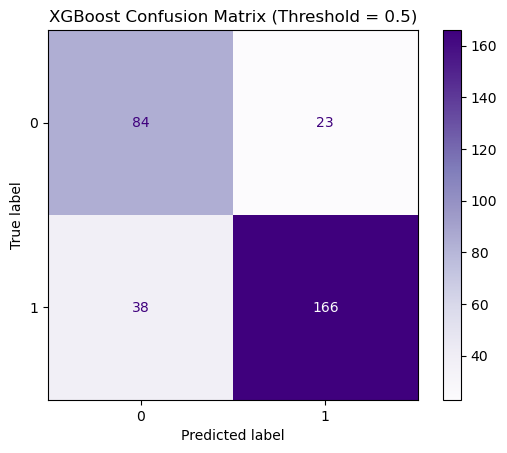

In [74]:
# Predict and evaluate on the test set
y_pred = final_xgb.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_xgb.named_steps['classifier'].classes_)
disp.plot(cmap='Purples')
plt.title('XGBoost Confusion Matrix (Threshold = 0.5)')
plt.show()

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       107
           1       0.85      0.86      0.86       204

    accuracy                           0.81       311
   macro avg       0.79      0.79      0.79       311
weighted avg       0.81      0.81      0.81       311



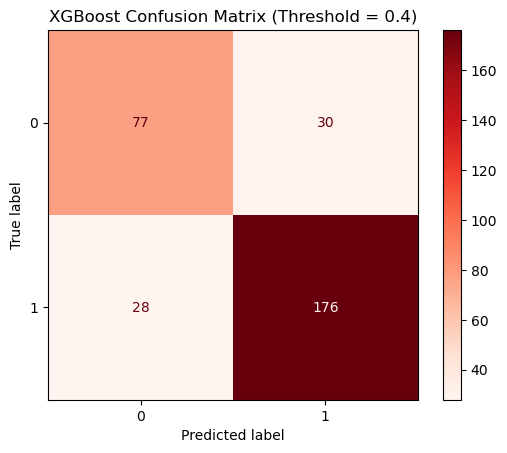

In [ ]:
# Lower the threshold to catch more biased sentences
threshold = 0.4

# Get predicted probabilities for the positive class
y_probs = xgb.predict_proba(X_test)[:, 1]
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate at custom threshold
print(classification_report(y_test, y_pred_custom))

# Plot confusion matrix for custom threshold
cm_custom = confusion_matrix(y_test, y_pred_custom)
disp_custom = ConfusionMatrixDisplay(confusion_matrix=cm_custom, display_labels=xgb.named_steps['classifier'].classes_)
disp_custom.plot(cmap='Reds')
plt.title(f'XGBoost Confusion Matrix (Threshold = {threshold})')
plt.show()


In [71]:
## Feature importance
# Extract importances from XGBoost
importances = final_xgb.named_steps['classifier'].feature_importances_

# Create a dataframe and sort
fi_df = pd.DataFrame({'feature': all_features, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False)

print("\nTop 20 most important features:\n")
print(fi_df.head(20))


Top 20 most important features:

                                          feature  importance
1028                               n_biased_words    0.088127
1007                             outlet_usa-today    0.018735
1002                            outlet_federalist    0.016824
1000                              outlet_alternet    0.015916
961                                          week    0.014401
1022                                  type_center    0.014261
1017                                  topic_sport    0.012923
924                                 united states    0.012306
906                                         trump    0.012053
320                                         first    0.011952
1015  topic_international-politics-and-world-news    0.011706
988                                         world    0.011686
1008                               topic_abortion    0.011531
112                                         biden    0.011012
379                                 

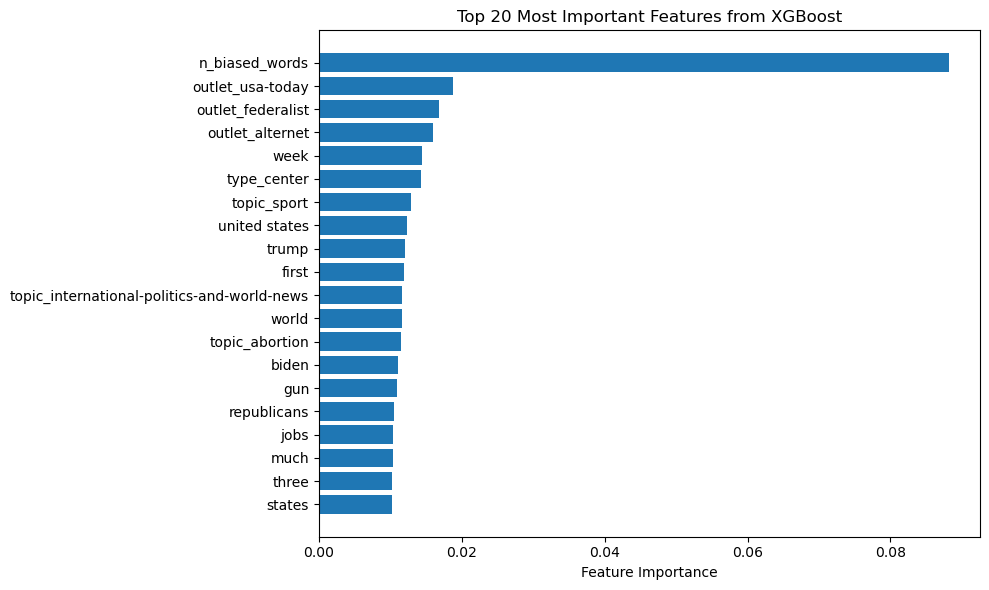

In [73]:
# Plot top feature importance
top_n = 20
plt.figure(figsize=(10,6))
plt.barh(fi_df['feature'].head(top_n)[::-1], fi_df['importance'].head(top_n)[::-1])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features from XGBoost')
plt.tight_layout()
plt.show()